In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import os
import random

In [2]:
# make dummy column own my way
def make_dummy(data):
    for i in range(27):
        data[f"category_{i+1}"] = [1 if category == (i+1) else 0 for category in data['category_id']]
    return data

In [3]:
# Convert the data to a 2D array for training the LSTM model
def prepare_data(data, n_steps, threshold):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix >= len(data):
            break
        # only consider rows where the date_gap is less than the threshold
        if data.loc[end_ix, 'time_gap_minutes'] < threshold:
            # extract the input and output sequences
            seq_X, seq_y = data.iloc[i:end_ix, :-1].values, data.loc[end_ix, ['views_scaled','vpm_scaled']]
            X.append(seq_X)
            y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
#학습데이터 구성을 위한 파일 이름 섞기

#shuffle for data split, 
directory = 'DATA/videos_preprocessed'
filenames= os.listdir(directory)
series_dict = {}

# Group the list elements by series
for file in filenames:
    series_name = file.split('_')[1]  # Extract the series name
    if series_name not in series_dict:
        series_dict[series_name] = []
    series_dict[series_name].append(file)

# Shuffle the order of the series
series_list = list(series_dict.keys())
random.shuffle(series_list)

# Concatenate the shuffled series
shuffled_lst = []
for series_name in series_list:
    shuffled_lst += series_dict[series_name]

#result aht contatins shuffled filenames
shuffled_lst


['Endless Adventure_50 state camper van road trip_20230509.csv',
 'EO_실리콘밸리댄스_20230509.csv',
 '낄낄상회_가졳같은회사_20230509.csv',
 '조현아_조현아의 목요일 밤_20230509.csv',
 'KCC_프로출근러_20230509.csv',
 'Be on Cloud_Be on Cloud Voyage_20230509.csv',
 '피식대학_05학번이즈히어_20230509.csv',
 '제일기획_제일엔터테인먼트_20230509.csv',
 'Be on Cloud_Be on Game_20230509.csv',
 '뜬뜬_핑계고_20230509.csv',
 '곽튜브_찐따록_20230509.csv',
 'Stray Kids_SKZ Code_20230509.csv',
 'KCC_K씨씨대학교_20230509.csv',
 'MovieHQ_Hogwarts Legacy_20230509.csv',
 'Toogii_Hogwarts Legacy_20230509.csv',
 '채코제_아메리카 여행_20230509.csv',
 'Toogii_Cafeowner Simulator_20230509.csv',
 'Bangtan TV_슈취타_20230509.csv',
 'DeeALup_Mass Effect Legendary Edition_20230509.csv',
 '뜬뜬_빰빰소셜클럽_20230509.csv',
 '재밌는 거 올라온다_또간집_20230509.csv',
 'Samuel and Audrey_Renovating hotel in Argentina_20230509.csv',
 '쿠첸_먹어BAR_20230509.csv',
 'Jet Lag_New Zealand_20230509.csv',
 'WildLens_Inda_20230509.csv',
 'GLITCH_MURDER DRONE_20230509.csv',
 'KBS KPOP_아이돌 인간극장_20230509.csv',
 '글자네_단퐁회_20230509.csv',

In [5]:
#학습데이터 구성

# set the directory path containing the CSV files
directory = 'DATA/videos_preprocessed'
columns = ['category_id', 'duration', 'update_diff', 'views_scaled', 'likes_scaled', 'vpm_scaled','time_gap_minutes']

# set the desired n_steps and threshold values
n_steps = 3
threshold = 43200
initX, inity = np.zeros((1,3,6)), np.zeros((1,2))
X = np.zeros((1,3,6))
y = np.zeros((1,2))

# iterate over the files in the directory
for filename in shuffled_lst:
    # load the CSV file
    filepath = os.path.join(directory, filename)
    data = pd.read_csv(filepath)
    data = data[columns]

    #simple pre-processing to make one hot vector for category.
    data = make_dummy(data)
    data.drop(['category_id'],axis=1,inplace=True)

        
    # prepare the data using the prepare_data() function
    tmpX, tmpy = prepare_data(data, n_steps=n_steps, threshold=threshold)
    # print(f"{filename}, x: {X.shape}, tmpx: {tmpX.shape}")
    if not np.array_equal(X,initX):
        if (tmpX.shape[1:3] == X.shape[1:3]):
            X = np.concatenate((X,tmpX),axis=0)
            y = np.concatenate((y,tmpy),axis=0)
    else:
        X = tmpX
        y = tmpy
        
    print(f'Prepared data for file {filename}: X shape = {X.shape}, y shape = {y.shape}')

Prepared data for file Endless Adventure_50 state camper van road trip_20230509.csv: X shape = (4, 3, 32), y shape = (4, 2)
Prepared data for file EO_실리콘밸리댄스_20230509.csv: X shape = (6, 3, 32), y shape = (6, 2)
Prepared data for file 낄낄상회_가졳같은회사_20230509.csv: X shape = (6, 3, 32), y shape = (6, 2)
Prepared data for file 조현아_조현아의 목요일 밤_20230509.csv: X shape = (10, 3, 32), y shape = (10, 2)
Prepared data for file KCC_프로출근러_20230509.csv: X shape = (11, 3, 32), y shape = (11, 2)
Prepared data for file Be on Cloud_Be on Cloud Voyage_20230509.csv: X shape = (11, 3, 32), y shape = (11, 2)
Prepared data for file 피식대학_05학번이즈히어_20230509.csv: X shape = (16, 3, 32), y shape = (16, 2)
Prepared data for file 제일기획_제일엔터테인먼트_20230509.csv: X shape = (20, 3, 32), y shape = (20, 2)
Prepared data for file Be on Cloud_Be on Game_20230509.csv: X shape = (21, 3, 32), y shape = (21, 2)
Prepared data for file 뜬뜬_핑계고_20230509.csv: X shape = (24, 3, 32), y shape = (24, 2)
Prepared data for file 곽튜브_찐따록_20230509.c

In [16]:
data.to_csv('preprocess.csv')

In [6]:
# Split the data into training and testing sets
# y = np.reshape(y, (32, ))  # reshape y to [32, 1]
split_idx = int(len(X) * 0.8) # 80% of the data will be used for training
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Dropout(0.2))
model.add(Dense(2))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/50
10/10 [==============================] - 3s 52ms/step - loss: 41.5104 - val_loss: 43.9969
Epoch 2/50
10/10 [==============================] - 0s 6ms/step - loss: 38.1879 - val_loss: 41.8744
Epoch 3/50
10/10 [==============================] - 0s 6ms/step - loss: 38.1836 - val_loss: 41.4136
Epoch 4/50
10/10 [==============================] - 0s 6ms/step - loss: 38.9817 - val_loss: 41.4451
Epoch 5/50
10/10 [==============================] - 0s 6ms/step - loss: 37.7085 - val_loss: 41.5127
Epoch 6/50
10/10 [==============================] - 0s 6ms/step - loss: 37.6429 - val_loss: 41.6865
Epoch 7/50
10/10 [==============================] - 0s 6ms/step - loss: 37.3345 - val_loss: 41.4647
Epoch 8/50
10/10 [==============================] - 0s 6ms/step - loss: 37.7643 - val_loss: 40.9312
Epoch 9/50
10/10 [==============================] - 0s 6ms/step - loss: 36.9483 - val_loss: 40.4979
Epoch 10/50
10/10 [==============================] - 0s 6ms/step - loss: 36.9796 - val_loss: 40.390

In [6]:
print(f"X shape = {X.shape}, y shape = {y.shape}")

X shape = (932, 3, 6), y shape = (932, 2)


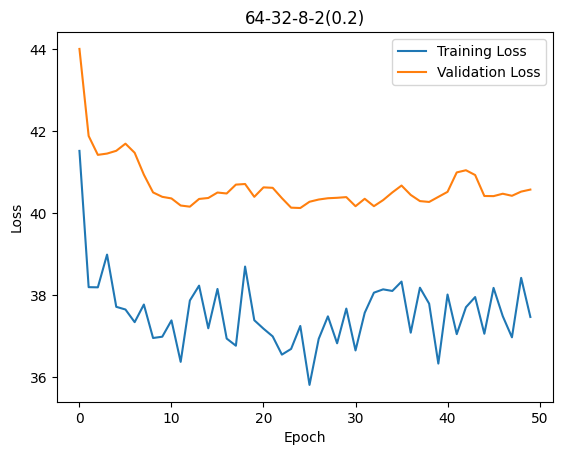

In [7]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('64-32-8-2(0.2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()